### Imports

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import torchtext
# import torchtext.data as ttd
import torchtext.legacy.data as ttd
%matplotlib inline

### Functions

In [63]:
def index_to_token(itos,sent):
    out = []
    for i in sent:
        out.append(itos[int(i)])

    return out

class CNN(nn.Module):
    def __init__(self,n_vocab, embed_dim, n_outputs):
        super(CNN,self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.K = n_outputs

        self.embed = nn.Embedding(self.V, self.D)


        self.conv1 = nn.Conv1d(in_channels=self.D, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc = nn.Linear(128, self.K)
        
    def forward(self, X):
        out = self.embed(X)

        out = out.permute(0,2,1)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = F.relu(out)

        out = out.permute(0,2,1)
        out, _ = torch.max(out, 1)

        out = self.fc(out)
        
        return out


class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, model_type, device):
        super(RNN,self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.model_type = model_type
        self.device = device
        
        self.embed = nn.Embedding(self.V, self.D)
        if self.model_type=="GRU":
            self.rnn = nn.GRU(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
        elif self.model_type=="LSTM":
            self.rnn = nn.LSTM(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
            
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        if self.model_type=="LSTM":
            c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
            out = self.embed(X)
            out,_ = self.rnn(out, (h0,c0))
        elif self.model_type=="GRU":
            out = self.embed(X)
            out,_ = self.rnn(out, h0)
        
        out,_ = torch.max(out, 1)
        out = self.fc(out)
        return out



def create_model_and_train(train_iter,test_iter,V,D,K,M=0,L=0,n_epochs=100,model_type="CNN"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    if model_type=="GRU":
        model = RNN(n_vocab=V ,embed_dim=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)
    elif model_type=="LSTM":
        model = RNN(n_vocab=V ,embed_dim=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)
    elif model_type=="CNN":
        model = CNN(n_vocab=V ,embed_dim=D, n_outputs=K)


    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs,targets in train_iter:
            targets = targets.view(-1,1).float()
            optimizer.zero_grad()
        
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        train_losses[it] = np.mean(train_loss)


        test_loss = []
        for inputs,targets in test_iter:
            targets = targets.view(-1,1).float()
        
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_losses[it] = np.mean(test_loss)

        dt = datetime.now() - t0

        if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}")
        
    return model,train_losses, test_losses


def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show


def acc_compouter(model,device,data_loader):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        # inputs,targets = inputs.to(device), targets.to(device)
        targets = targets.view(-1,1).float()

        outputs = model(inputs)
        
        predictions = (outputs>0)
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    acc = n_correct/n_total

    return acc

### Load data

In [32]:
df = pd.read_csv("./spam.csv", encoding="ISO-8859-1")

In [33]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [34]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [35]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
df.columns = ["labels", "data"]

In [37]:
df["b_labels"] = df["labels"].map({"ham":0, "spam":1})

In [38]:
df2 = df[["data","b_labels"]]

In [39]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [40]:
df2.to_csv("spam2.csv", index=False)

In [41]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = False,
    # tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True)

In [42]:
dataset = ttd.TabularDataset(
    path = 'spam2.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data',TEXT),('label',LABEL)]
)

In [43]:
# ex = dataset.examples[0]
# type(ex)
# ex.data
# ex.label

In [44]:
train_dataset , test_dataset = dataset.split() # default 0.7

In [45]:
TEXT.build_vocab(train_dataset)

In [46]:
vocab = TEXT.vocab

In [47]:
torchtext.vocab.Vocab

torchtext.vocab.Vocab

In [48]:
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fe154da4790>>,
            {'<unk>': 0,
             '<pad>': 1,
             'to': 2,
             'you': 3,
             'I': 4,
             'a': 5,
             'the': 6,
             'and': 7,
             'in': 8,
             'is': 9,
             'i': 10,
             'u': 11,
             'for': 12,
             'my': 13,
             'of': 14,
             'your': 15,
             'me': 16,
             'on': 17,
             '2': 18,
             'have': 19,
             'it': 20,
             'that': 21,
             'are': 22,
             'be': 23,
             'or': 24,
             'at': 25,
             'not': 26,
             'with': 27,
             'call': 28,
             'will': 29,
             'can': 30,
             'get': 31,
             'U': 32,
             'so': 33,
             '&lt;#&gt;': 34,
             'but': 35,
             'ur': 36,
             "I'm":

In [49]:
vocab.itos

['<unk>',
 '<pad>',
 'to',
 'you',
 'I',
 'a',
 'the',
 'and',
 'in',
 'is',
 'i',
 'u',
 'for',
 'my',
 'of',
 'your',
 'me',
 'on',
 '2',
 'have',
 'it',
 'that',
 'are',
 'be',
 'or',
 'at',
 'not',
 'with',
 'call',
 'will',
 'can',
 'get',
 'U',
 'so',
 '&lt;#&gt;',
 'but',
 'ur',
 "I'm",
 'from',
 'up',
 'You',
 'go',
 'do',
 '4',
 'just',
 'like',
 'if',
 'this',
 'we',
 'know',
 'out',
 '.',
 'all',
 'when',
 'was',
 '?',
 'come',
 'got',
 'now',
 'am',
 'time',
 'send',
 '...',
 'by',
 'Call',
 'want',
 'then',
 'about',
 "I'll",
 'only',
 'n',
 'what',
 'still',
 'How',
 'need',
 'text',
 'But',
 'as',
 'there',
 'one',
 'If',
 'going',
 'its',
 'Just',
 'some',
 'We',
 'he',
 'been',
 'our',
 'No',
 'love',
 'no',
 'So',
 'any',
 'take',
 'What',
 'Do',
 'day',
 'good',
 'home',
 'Your',
 'has',
 'tell',
 'think',
 '&',
 "don't",
 'her',
 'back',
 'r',
 'see',
 'The',
 'My',
 'how',
 'And',
 'an',
 'make',
 'Ì_',
 'mobile',
 'Ok',
 'free',
 'more',
 'phone',
 'FREE',
 'later

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset,test_dataset), sort_key = lambda x: len(x.data),
    batch_sizes = (32, 256), device=device
)

In [52]:
for inputs, targets in train_iter:
    print("inputs", inputs, "shape", inputs.shape)
    # for input in inputs:
    #     print(index_to_token(vocab.itos,input))
    print("targets", inputs, "shape", targets.shape)
    break

inputs tensor([[    1,     1,     1,  ...,  1704,   838,  2354],
        [    1,     1,     1,  ...,   113,    15,  2465],
        [    1,     1,     1,  ...,    26,  1281,  1048],
        ...,
        [    1,     1,     1,  ...,    77,   279,   182],
        [    1,     1,     1,  ...,  2044,     2,   126],
        [    1,     1,     1,  ..., 11324,    43,  8025]], device='cuda:0') shape torch.Size([32, 36])
targets tensor([[    1,     1,     1,  ...,  1704,   838,  2354],
        [    1,     1,     1,  ...,   113,    15,  2465],
        [    1,     1,     1,  ...,    26,  1281,  1048],
        ...,
        [    1,     1,     1,  ...,    77,   279,   182],
        [    1,     1,     1,  ...,  2044,     2,   126],
        [    1,     1,     1,  ..., 11324,    43,  8025]], device='cuda:0') shape torch.Size([32])


In [53]:
for inputs, targets in test_iter:
    print("inputs", inputs, "shape", inputs.shape)
    # for input in inputs:
    #     print(index_to_token(vocab.itos,input))
    print("targets", inputs, "shape", targets.shape)
    break

inputs tensor([[ 5978,    17,   181,    11,    81,   167],
        [  118,   524, 11817,   234,     8,     0],
        [  289,   438,   148,     5,    98,    97],
        ...,
        [    1,     1,     1,     1,     1,   543],
        [    1,     1,     1,     1,     1,  2327],
        [    1,     1,     1,     1,     1,   118]], device='cuda:0') shape torch.Size([256, 6])
targets tensor([[ 5978,    17,   181,    11,    81,   167],
        [  118,   524, 11817,   234,     8,     0],
        [  289,   438,   148,     5,    98,    97],
        ...,
        [    1,     1,     1,     1,     1,   543],
        [    1,     1,     1,     1,     1,  2327],
        [    1,     1,     1,     1,     1,   118]], device='cuda:0') shape torch.Size([256])


### Create and train model

In [64]:
model,train_losses, test_losses = create_model_and_train(train_iter,test_iter,V=len(vocab),D=20,K=1,n_epochs=50,model_type="CNN")

cuda:0
Epoch 5/50, Train Loss: 0.0777, Test Loss: 0.2111
Epoch 10/50, Train Loss: 0.0151, Test Loss: 0.1601
Epoch 15/50, Train Loss: 0.0034, Test Loss: 0.1894
Epoch 20/50, Train Loss: 0.0009, Test Loss: 0.2145
Epoch 25/50, Train Loss: 0.0023, Test Loss: 0.2682
Epoch 30/50, Train Loss: 0.0001, Test Loss: 0.2591
Epoch 35/50, Train Loss: 0.0000, Test Loss: 0.2626
Epoch 40/50, Train Loss: 0.0000, Test Loss: 0.2717
Epoch 45/50, Train Loss: 0.0000, Test Loss: 0.2816
Epoch 50/50, Train Loss: 0.0000, Test Loss: 0.2887


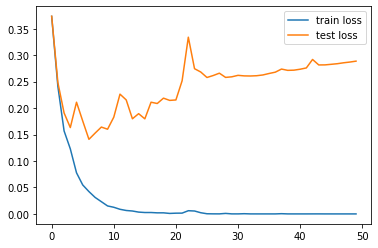

In [65]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

In [66]:
acc_compouter(model,device,train_iter)

1.0

In [67]:
acc_compouter(model,device,test_iter)

0.965311004784689